# a vine copula (vinecop) application on financial (US ETFs) dependence modeling and simulation.

- data preprocessing and exploratory data analysis
- make marginal cdf/ppf, transform from raw return to copula data
- fit 'rvine', draw, do full simulation
- fit 'cvine', draw, do cond simulation (given **SPY** scenario)


## initialization, fetch data, preprocess


In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yfinance as yf

# * add proj root folder into path
sys.path.append("..")
import torchvinecopulib as tvc

lst_ticker = [
    "SPY",
    "QQQ",
    "DIA",
    "IJH",
    "VTI",
    "IWM",
    "XLF",
    "XLE",
    "XLK",
    "EFA",
    "EWA",
    "EWJ",
    "EEM",
    "FXI",
    "AGG",
    "TLT",
    "GLD",
    "SLV",
    "USO",
    "UNG",
]
print(lst_ticker)
raw_df = yf.download(lst_ticker, start="2010-01-01")
raw_df.index = pd.DatetimeIndex(raw_df.index)
raw_df = raw_df["Adj Close"].ffill()
# calc simple retn
NUM_DAY_INTVL = 1
df_retn_adjclose_simple_last_intvl = np.expm1(
    np.log(raw_df)[::NUM_DAY_INTVL].diff(1).dropna()
)
#
NUM_SIM = 50000
print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

['SPY', 'QQQ', 'DIA', 'IJH', 'VTI', 'IWM', 'XLF', 'XLE', 'XLK', 'EFA', 'EWA', 'EWJ', 'EEM', 'FXI', 'AGG', 'TLT', 'GLD', 'SLV', 'USO', 'UNG']


[*********************100%***********************]  20 of 20 completed


cuda (GPU) avail? True



### chart rolling bidep between each asset and SPY


In [2]:
f_bidep = lambda a, b: tvc.util.kendall_tau(a, b)[0]
dct_dep_spy = {}
for df in df_retn_adjclose_simple_last_intvl.rolling(
    window=252 // NUM_DAY_INTVL, step=int(np.sqrt(252) // NUM_DAY_INTVL)
):
    if df.shape[0] >= 252 // NUM_DAY_INTVL:
        dct_dep_spy[df.index[-1]] = {
            k: f_bidep(
                torch.from_numpy(df[[k]].values), torch.from_numpy(df[["SPY"]].values)
            )
            for k in df.keys()
        }

Text(0.5, 1.0, 'Rolling bivariate dependence (kendall_tau), between ETFs and SPY.')

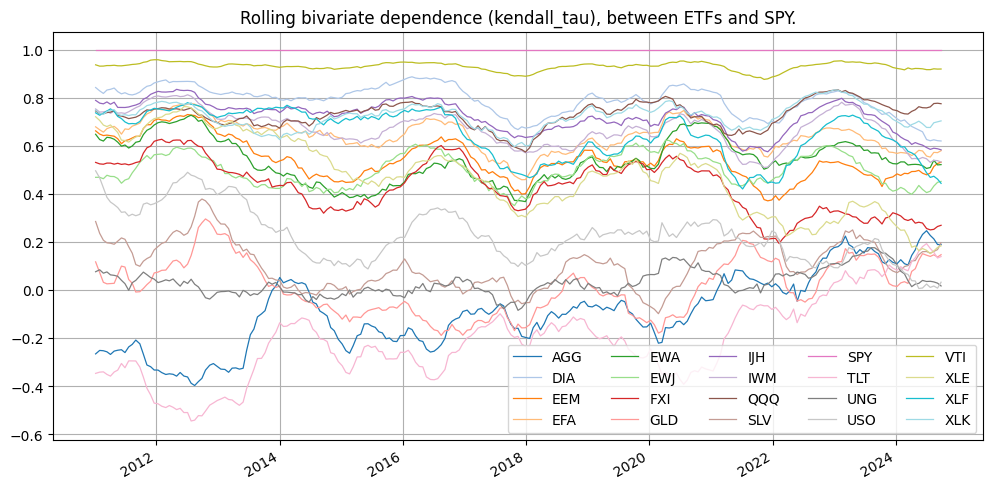

In [3]:
pd.DataFrame(dct_dep_spy).T.plot(
    figsize=(12, 6), style="-", alpha=1, lw=0.9, colormap="tab20"
)
plt.legend(ncol=5)
plt.grid()
plt.title(f"Rolling bivariate dependence (kendall_tau), between ETFs and SPY.")

### make marginal cdf_ppf functions; transform from raw data (-∞,∞)-> copula data (0,1)


In [4]:
from scipy import stats
from random import seed as r_seed
from scipy.special import ndtr
from scipy.interpolate import CubicSpline


def make_cdf_ppf(
    vec_obs: np.array,
    mtd_margin: str,
    seed: int = 0,
    lst_distribution: list = [
        stats.norm,
        stats.t,
        stats.nct,
        stats.laplace,
        stats.laplace_asymmetric,
        stats.johnsonsu,
        # stats.tukeylambda,
    ],
) -> pd.Series:
    """fit marginal univariate distributions, return fitted cdf/ppf functions
    # ! band_width for np fit from:
    Dhaker, H., Deme, E. H., & Ciss, Y. (2021).
    β-Divergence loss for the kernel density estimation with bias reduced.
    Statistical Theory and Related Fields, 5(3), 221-231.
    """
    r_seed(seed)
    np.random.seed(seed=seed)
    vec_clean = np.sort(vec_obs[np.isfinite(vec_obs)])
    if mtd_margin == "np":
        # The constant has beta = 1.7320508075688772 from
        # (4 * beta**4 / (9 * beta**4 - 36 * beta**3 + 90 * beta**2 + 270 * beta + 105) * sqrt(2 / pi))**(1 / 9)
        band_width = vec_clean.std() * 0.6973425390765554 * (len(vec_clean)) ** (-1 / 9)

        # empirical cdf, semi parametric approach, from mixture
        @np.vectorize
        def res_cdf(quantile: np.array):
            # ±∞ return to (0,1) cdf
            return ndtr((quantile - vec_clean) / band_width).mean()

        vec_F, idx = np.unique(res_cdf(vec_clean), return_index=True)
        func_spline = CubicSpline(x=vec_F, y=vec_clean[idx])
        eps = 1 / (len(vec_clean) + 1)

        def res_ppf(percentage: np.array):
            # (0,1) cdf to ±∞ return
            return func_spline(np.clip(a=percentage, a_min=eps, a_max=1 - eps))

    elif mtd_margin == "p":
        dist, par, bic2, lnn2 = None, None, np.inf, np.log(len(vec_clean)) / 2
        for iter_dist in lst_distribution:
            iter_par = iter_dist.fit(vec_clean)
            iter_bic2 = (
                len(iter_par) * lnn2 - iter_dist.logpdf(vec_clean, *iter_par).sum()
            )
            if iter_bic2 < bic2:
                dist, par, bic2 = iter_dist, iter_par, iter_bic2
        res_cdf, res_ppf = (
            lambda vec: dist.cdf(vec, *par),
            lambda vec: dist.ppf(vec, *par),
        )

    return pd.Series({"cdf": res_cdf, "ppf": res_ppf})

In [5]:
arr_cdf_ppf = np.apply_along_axis(
    func1d=lambda vec: make_cdf_ppf(vec_obs=vec, mtd_margin="np", seed=0),
    axis=0,
    arr=df_retn_adjclose_simple_last_intvl.values,
)

In [6]:
V_mvcp = torch.as_tensor(
    np.hstack(
        [
            cdf(df_retn_adjclose_simple_last_intvl.values[:, [idx]])
            for idx, cdf in enumerate(arr_cdf_ppf[0])
        ]
    ),
    device=DEVICE,
)
print(V_mvcp.min(), V_mvcp.max())

tensor(0.0001, device='cuda:0', dtype=torch.float64) tensor(0.9999, device='cuda:0', dtype=torch.float64)


## rvine, full sim

> make rvine from multivariate copula observations, **full sim**


In [7]:
# read tpl_sim from right to left
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp)
print(mdl_vcp)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 20,
 'num_obs': 3_714,
 'num_par': 125,
 'negloglik': -57810.7511,
 'aic': -115371.5022,
 'bic': -114594.0191,
 'matrix': '[[ 7  9 15 14  0 17 13  8 16 18 19 10  1 12  6  5  2  3  4 11]'
           ' [-1  9  5 11  4  6  2 14 19  0  3 13 10 15 18 17  1 12 16  8]'
           ' [-1 -1  5 15 14  0 17 13  8 16 18 19 10  1 12  6 11  2  4  3]'
           ' [-1 -1 -1 11 15 14  0 17 13  8 16 18 19 10  1 12  6  2  3  4]'
           ' [-1 -1 -1 -1  4 15 14  0 17 13  8 16 18 19 10  1 12  6  2  3]'
           ' [-1 -1 -1 -1 -1  6 15 14  0 17 13  8 16 18 19 10  1 12  3  2]'
           ' [-1 -1 -1 -1 -1 -1  2 15 14  0 17 13  8 16 18 19 10  1 12  3]'
           ' [-1 -1 -1 -1 -1 -1 -1 14 15 19 17  3  8 16 10 12  1 18  0 13]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 15 19  0  3 13 10 18  1 12 16  8 17]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1  0 19 17  3  8 16 10 12  1 18 13]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 17 19  3 13 10 18  1 12 16  8]'
          

In [8]:
for _ in enumerate(df_retn_adjclose_simple_last_intvl.columns):
    print(_)

(0, 'AGG')
(1, 'DIA')
(2, 'EEM')
(3, 'EFA')
(4, 'EWA')
(5, 'EWJ')
(6, 'FXI')
(7, 'GLD')
(8, 'IJH')
(9, 'IWM')
(10, 'QQQ')
(11, 'SLV')
(12, 'SPY')
(13, 'TLT')
(14, 'UNG')
(15, 'USO')
(16, 'VTI')
(17, 'XLE')
(18, 'XLF')
(19, 'XLK')


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x17af7308370>)

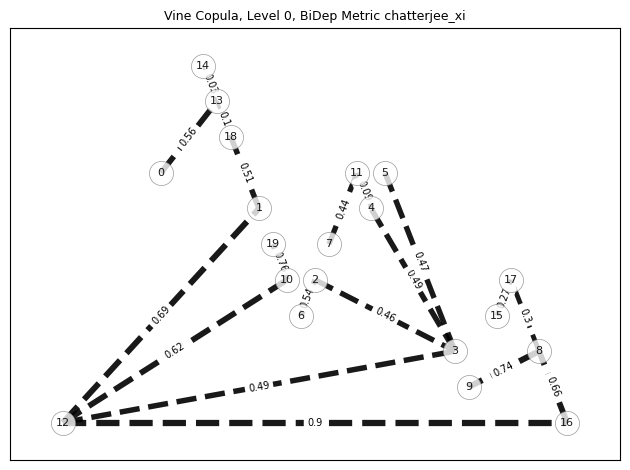

In [9]:
# SPY is vertex 12
mdl_vcp.draw_lv()

In [10]:
print(mdl_vcp.tpl_sim)
V_sim = mdl_vcp.sim(num_sim=NUM_SIM, device=DEVICE, is_sobol=True)
print(V_sim)

(7, 9, 5, 11, 4, 6, 2, 14, 15, 0, 17, 13, 8, 16, 18, 19, 3, 1, 10, 12)
tensor([[0.9672, 0.4672, 0.6637,  ..., 0.5487, 0.2395, 0.6737],
        [0.1361, 0.8942, 0.8110,  ..., 0.8597, 0.8708, 0.6281],
        [0.0967, 0.4588, 0.4250,  ..., 0.2456, 0.8433, 0.7259],
        ...,
        [0.3243, 0.7827, 0.6790,  ..., 0.8854, 0.8040, 0.5165],
        [0.6339, 0.7916, 0.7103,  ..., 0.9793, 0.3076, 0.8923],
        [0.7871, 0.3524, 0.4047,  ..., 0.3102, 0.5010, 0.2410]],
       device='cuda:0', dtype=torch.float64)


In [11]:
arr_sim = np.hstack(
    [ppf(V_sim[:, [idx]].cpu()) for idx, ppf in enumerate(arr_cdf_ppf[1])]
)

print(arr_sim.min(), arr_sim.max())
print(
    "\nkendall tau wrt SPY, of simulations\n",
    pd.DataFrame(arr_sim, columns=df_retn_adjclose_simple_last_intvl.columns).corr(
        method="kendall"
    )["SPY"],
)
print(
    "\nkendall tau wrt SPY, of raw obs\n",
    df_retn_adjclose_simple_last_intvl.corr(method="kendall")["SPY"],
)

-0.25333608814396846 0.17960293369111177

kendall tau wrt SPY, of simulations
 Ticker
AGG   -0.072683
DIA    0.786825
EEM    0.548489
EFA    0.643312
EWA    0.555600
EWJ    0.502424
FXI    0.419754
GLD    0.042223
IJH    0.720530
IWM    0.668199
QQQ    0.737186
SLV    0.139487
SPY    1.000000
TLT   -0.198325
UNG    0.018076
USO    0.251672
VTI    0.931849
XLE    0.473646
XLF    0.642709
XLK    0.725255
Name: SPY, dtype: float64

kendall tau wrt SPY, of raw obs
 Ticker
AGG   -0.073245
DIA    0.786823
EEM    0.547333
EFA    0.643280
EWA    0.547771
EWJ    0.500030
FXI    0.424662
GLD    0.030018
IJH    0.719313
IWM    0.669848
QQQ    0.737191
SLV    0.133994
SPY    1.000000
TLT   -0.198484
UNG    0.039623
USO    0.229252
VTI    0.931820
XLE    0.458630
XLF    0.637686
XLK    0.723410
Name: SPY, dtype: float64


## rvine, cond sim

> make rvine from multivariate copula observations, **cond sim**


In [12]:
# user specify the priority vertices list, used in fitting and also in the conditional simulation
mdl_vcp_cond = tvc.vinecop.vcp_from_obs(
    V_mvcp,
    tpl_first=(12,),
    mtd_vine="cvine",
    mtd_bidep="ferreira_tail_dep_coeff",
)

print(mdl_vcp_cond)

{'mtd_bidep': 'ferreira_tail_dep_coeff',
 'num_dim': 20,
 'num_obs': 3_714,
 'num_par': 128,
 'negloglik': -57481.8152,
 'aic': -114707.6303,
 'bic': -113911.4876,
 'matrix': '[[14  2 13  1 15  8  4  5 18 11 19  6  9  0  7 16 10  3 17 12]'
           ' [-1  2 13  1 15  8  4  5 18 11 19  6  9  0  7 16 10  3 17 12]'
           ' [-1 -1 13  1 15  8  4  5 18 11 19  6  9  0  7 16 10  3 17 12]'
           ' [-1 -1 -1  1 15  8  4  5 18 11 19  6  9  0  7 16 10  3 17 12]'
           ' [-1 -1 -1 -1 15  8  4  5 18 11 19  6  9  0  7 16 10  3 17 12]'
           ' [-1 -1 -1 -1 -1  8  4  5 18 11 19  6  9  0  7 16 10  3 17 12]'
           ' [-1 -1 -1 -1 -1 -1  4  5 18 11 19  6  9  0  7 16 10  3 17 12]'
           ' [-1 -1 -1 -1 -1 -1 -1  5 18 11 19  6  9  0  7 16 10  3 17 12]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 18 11 19  6  9  0  7 16 10  3 17 12]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 11 19  6  9  0  7 16 10  3 17 12]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 19  6  9  0  7 16 10  3 17 12]'


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric ferreira_tail_dep_coeff'}>,
 <networkx.classes.graph.Graph at 0x17af76ffeb0>)

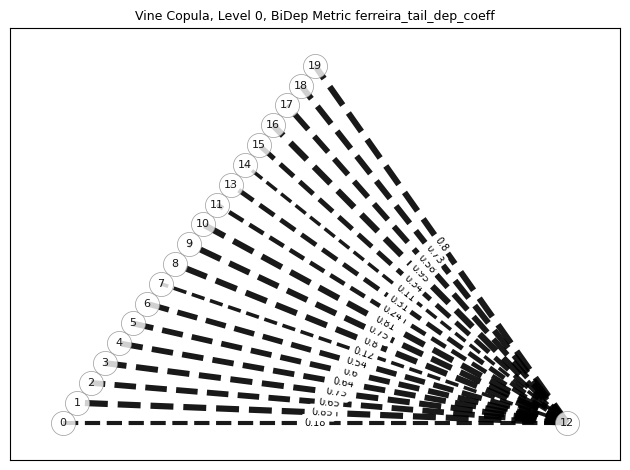

In [13]:
# SPY is vertex 12
mdl_vcp_cond.draw_lv()

In [14]:
# cond sim: user specified values for first set (vertex 12),
# a tail scenario with CDF(SPY)=.05
dct_first_vs = {
    (12, frozenset()): torch.ones(size=(NUM_SIM, 1), device=DEVICE) * (0.05)
}
V_sim_cond = mdl_vcp.sim(
    num_sim=NUM_SIM, dct_first_vs=dct_first_vs, device=DEVICE, is_sobol=True
)
arr_sim_cond = np.hstack(
    [ppf(V_sim_cond[:, [idx]].cpu()) for idx, ppf in enumerate(arr_cdf_ppf[1])]
)
print("specified value of SPY:", arr_sim_cond[:, 12])
print(arr_sim_cond[:3, :])

specified value of SPY: [-0.0171685 -0.0171685 -0.0171685 ... -0.0171685 -0.0171685 -0.0171685]
[[-0.00062196 -0.01482639 -0.00836499 -0.01462424 -0.01737533 -0.01921303
   0.00088985  0.02987426 -0.02543628 -0.02194299 -0.01925726  0.01761725
  -0.0171685  -0.00124867  0.03352915  0.00865678 -0.01855654 -0.01001041
  -0.01005144 -0.02106399]
 [ 0.00186375 -0.01747018 -0.01669292 -0.01364371 -0.01384985 -0.0079214
  -0.018345   -0.00389636 -0.01550523 -0.01725644 -0.00896077 -0.01124805
  -0.0171685   0.01792265 -0.00946006 -0.01918642 -0.01693218 -0.0230866
  -0.04024478 -0.01114939]
 [ 0.00278947 -0.01204225 -0.02332257 -0.02759581 -0.01371566 -0.00549764
  -0.01688978 -0.00948362 -0.02073643 -0.01221219 -0.01467971 -0.0126809
  -0.0171685   0.01779743 -0.03631711 -0.1250514  -0.01773216 -0.06059075
  -0.02145742 -0.02081509]]
